<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study2_2_%5Bnomic%5D_autoencoder_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Nomic] Autoencoder: Generate Corresponding Embedding

## Set Up

### Imports

In [1]:
import os
import subprocess
import zipfile
import shutil
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import userdata
from scipy import spatial
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from plotnine import ggplot, geom_line, aes, ggsave, labs, theme, element_text, guides, guide_legend, scale_y_continuous

### OSF Setup

In [2]:
!pip install osfclient

In [3]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [4]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [5]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [6]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

## Data

### Load embeddings data from OSF

In [7]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/nomic-autoencoder/nomic_embeddings_dump.zip", shell=True)
print("nomic_embeddings_dump.zip successfully imported")

nomic_embeddings_dump_file_path_zip = 'nomic_embeddings_dump.zip'
nomic_embeddings_dump_file_path = 'current-data-dump/embeddings-dump'
with zipfile.ZipFile(nomic_embeddings_dump_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(nomic_embeddings_dump_file_path)

extracted_files = os.listdir(nomic_embeddings_dump_file_path)
print("Files extracted:", extracted_files)

nomic_embeddings_dump.zip successfully imported
Files extracted: ['test_sd_embeddings.pkl', 'test_cla_embeddings.pkl', 'training_sq_embeddings.pkl', 'training_clu_embeddings.pkl', 'training_cla_embeddings.pkl', 'training_sd_embeddings.pkl', 'test_clu_embeddings.pkl', 'test_sq_embeddings.pkl', '.ipynb_checkpoints']


### Functions to prepare data

In [8]:
def prepare_training_df(data: pd.DataFrame):
  """Drop rows that do not follow 'point' -> 'counter' pattern"""
  point_indices = data[data['type'] == 'point'].index
  counter_indices = data[data['type'] == 'counter'].index
  drop_indices = []
  for idx in point_indices:
    if (idx == len(data)-1) or (idx + 1 < len(data) and data.loc[idx + 1, 'type'] != 'counter'):
      drop_indices.append(idx)
  for idx in counter_indices:
    if idx > 0 and data.loc[idx - 1, 'type'] != 'point':
      drop_indices.append(idx)
  data = data.drop(drop_indices)
  data = data.select_dtypes(include=[np.number])
  data = data.reset_index(drop=True)
  return data

In [9]:
def prepare_training_df_shuffled(data: pd.DataFrame):
  """Drop rows that do not follow 'point' -> 'counter' pattern"""
  point_indices = data[data['type'] == 'point'].index
  counter_indices = data[data['type'] == 'counter'].index
  drop_indices = []
  for idx in point_indices:
    if (idx == len(data)-1) or (idx + 1 < len(data) and data.loc[idx + 1, 'type'] != 'counter'):
      drop_indices.append(idx)
  for idx in counter_indices:
    if idx > 0 and data.loc[idx - 1, 'type'] != 'point':
      drop_indices.append(idx)
  data = data.drop(drop_indices)
  data = data.reset_index(drop=True)
  return data

In [10]:
def make_x(data: pd.DataFrame) -> pd.DataFrame:
  x_train = data[data.index % 2 == 0].reset_index(drop=True)
  return x_train

def make_y(data: pd.DataFrame) -> pd.DataFrame:
  y_train = data[data.index % 2 != 0].reset_index(drop=True)
  return y_train

### Global data

In [11]:
training_sd_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/training_sd_embeddings.pkl")
training_sq_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/training_sq_embeddings.pkl")
training_clu_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/training_clu_embeddings.pkl")
training_cla_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/training_cla_embeddings.pkl")

test_sd_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/test_sd_embeddings.pkl")
test_sq_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/test_sq_embeddings.pkl")
test_clu_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/test_clu_embeddings.pkl")
test_cla_embeddings_data = pd.read_pickle("current-data-dump/embeddings-dump/test_cla_embeddings.pkl")

In [12]:
train_sd = prepare_training_df(training_sd_embeddings_data)
train_sq = prepare_training_df(training_sq_embeddings_data)
train_clu = prepare_training_df(training_clu_embeddings_data)
train_cla = prepare_training_df(training_cla_embeddings_data)

test_sd = prepare_training_df(test_sd_embeddings_data)
test_sq = prepare_training_df(test_sq_embeddings_data)
test_clu = prepare_training_df(test_clu_embeddings_data)
test_cla = prepare_training_df(test_cla_embeddings_data)

In [13]:
x_train_sd = make_x(train_sd)
x_train_sq = make_x(train_sq)
x_train_clu = make_x(train_clu)
x_train_cla = make_x(train_cla)

y_train_sd = make_y(train_sd)
y_train_sq = make_y(train_sq)
y_train_clu = make_y(train_clu)
y_train_cla = make_y(train_cla)

In [14]:
x_test_sd = make_x(test_sd)
x_test_sq = make_x(test_sq)
x_test_clu = make_x(test_clu)
x_test_cla = make_x(test_cla)

y_test_sd = make_y(test_sd)
y_test_sq = make_y(test_sq)
y_test_clu = make_y(test_clu)
y_test_cla = make_y(test_cla)

### Global data shuffled

In [15]:
y_train_shuffled_sd = prepare_training_df_shuffled(training_sd_embeddings_data)
y_train_shuffled_sq = prepare_training_df_shuffled(training_sq_embeddings_data)
y_train_shuffled_clu = prepare_training_df_shuffled(training_clu_embeddings_data)
y_train_shuffled_cla = prepare_training_df_shuffled(training_cla_embeddings_data)

In [16]:
y_train_shuffled_sd = make_y(y_train_shuffled_sd)
y_train_shuffled_sq = make_y(y_train_shuffled_sq)
y_train_shuffled_clu = make_y(y_train_shuffled_clu)
y_train_shuffled_cla = make_y(y_train_shuffled_cla)

In [17]:
y_train_shuffled_sd = y_train_shuffled_sd.groupby(['topic'], sort=False)
y_train_shuffled_sd = y_train_shuffled_sd.sample(frac=1).reset_index(drop=True)
y_train_shuffled_sd = y_train_shuffled_sd.select_dtypes(include=[np.number])

y_train_shuffled_sq = y_train_shuffled_sq.groupby(['topic'], sort=False)
y_train_shuffled_sq = y_train_shuffled_sq.sample(frac=1).reset_index(drop=True)
y_train_shuffled_sq = y_train_shuffled_sq.select_dtypes(include=[np.number])

y_train_shuffled_clu = y_train_shuffled_clu.groupby(['topic'], sort=False)
y_train_shuffled_clu = y_train_shuffled_clu.sample(frac=1).reset_index(drop=True)
y_train_shuffled_clu = y_train_shuffled_clu.select_dtypes(include=[np.number])

y_train_shuffled_cla = y_train_shuffled_cla.groupby(['topic'], sort=False)
y_train_shuffled_cla = y_train_shuffled_cla.sample(frac=1).reset_index(drop=True)
y_train_shuffled_cla = y_train_shuffled_cla.select_dtypes(include=[np.number])

## Model

### Architecture

In [18]:
# Layers
input_layer = tf.keras.layers.Input(shape=(768, ), name="Input")
hidden_layer = tf.keras.layers.Dense(units=768, activation="relu", name="Hidden")(input_layer)
output_layer = tf.keras.layers.Dense(units=768, activation="linear", name="Output")(hidden_layer)

In [19]:
# Model
autoencoder_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 768)]             0         
                                                                 
 Hidden (Dense)              (None, 768)               590592    
                                                                 
 Output (Dense)              (None, 768)               590592    
                                                                 
Total params: 1181184 (4.51 MB)
Trainable params: 1181184 (4.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
def metric_choose_argument_global_sd_y_train(y_true, y_pred):
  """global_sd_metric"""
  global_sd_training_df_32 = tf.cast(pd.concat([x_train_sd, y_train_sd, x_test_sd, y_test_sd]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_sd_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_sd_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_sd_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_sd_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

In [21]:
def metric_choose_argument_global_sq_y_train(y_true, y_pred):
  """global_sq_metric"""
  global_sq_training_df_32 = tf.cast(pd.concat([x_train_sq, y_train_sq, x_test_sq, y_test_sq]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_sq_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_sq_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_sq_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_sq_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

In [22]:
def metric_choose_argument_global_clu_y_train(y_true, y_pred):
  """global_clu_metric"""
  global_clu_training_df_32 = tf.cast(pd.concat([x_train_clu, y_train_clu, x_test_clu, y_test_clu]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_clu_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_clu_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_clu_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_clu_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

In [23]:
def metric_choose_argument_global_cla_y_train(y_true, y_pred):
  """global_cla_metric"""
  global_cla_training_df_32 = tf.cast(pd.concat([x_train_cla, y_train_cla, x_test_cla, y_test_cla]), dtype=tf.float32)

  cos_sim_pred = tf.matmul(global_cla_training_df_32, y_pred, transpose_b=True) / tf.reshape(tf.norm(y_pred) * tf.norm(global_cla_training_df_32, axis=1), [-1, 1])
  cos_sim_true = tf.matmul(global_cla_training_df_32, y_true, transpose_b=True) / tf.reshape(tf.norm(y_true) * tf.norm(global_cla_training_df_32, axis=1), [-1, 1])

  max_cos_sim_pred = tf.math.argmax(cos_sim_pred)
  max_cos_sim_true = tf.math.argmax(cos_sim_true)

  return tf.math.count_nonzero(tf.equal(max_cos_sim_pred, max_cos_sim_true))

### Compile

In [24]:
# Global SD Model
global_sd_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_sd_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_sd_y_train]
)

In [25]:
# Global SQ Model
global_sq_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_sq_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_sq_y_train]
)

In [26]:
# Global CLU Model
global_clu_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_clu_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_clu_y_train]
)

In [27]:
# Global CLA Model
global_cla_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_cla_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_cla_y_train]
)

In [28]:
# Global SD Model (Shuffled)
global_shuffled_sd_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_shuffled_sd_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_sd_y_train]
)

In [29]:
# Global SQ Model (Shuffled)
global_shuffled_sq_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_shuffled_sq_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_sq_y_train]
)

In [30]:
# Global CLU Model (Shuffled)
global_shuffled_clu_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_shuffled_clu_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_clu_y_train]
)

In [31]:
# Global CLA Model (Shuffled)
global_shuffled_cla_autoencoder_model = tf.keras.models.clone_model(autoencoder_model)
global_shuffled_cla_autoencoder_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss="cosine_similarity",
  metrics=[metric_choose_argument_global_cla_y_train]
)

## Unshuffled Training

In [33]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_sd_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_sd_training_log.csv', separator=',', append=True)

global_sd_history = global_sd_autoencoder_model.fit(
  x=x_train_sd,
  y=y_train_sd,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_sd, y_test_sd),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4054/4065 [============================>.] - ETA: 0s - loss: -0.8365 - metric_choose_argument_global_sd_y_train: 0.0446
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_sd_autoencoder_weights.keras
4065/4065 [==============================] - 27s 7ms/step - loss: -0.8366 - metric_choose_argument_global_sd_y_train: 0.0445 - val_loss: -0.8488 - val_metric_choose_argument_global_sd_y_train: 0.0585
Epoch 2/20
4061/4065 [============================>.] - ETA: 0s - loss: -0.8655 - metric_choose_argument_global_sd_y_train: 0.1022
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_sd_autoencoder_weights.keras
4065/4065 [==============================] - 30s 7ms/step - loss: -0.8655 - metric_choose_argument_global_sd_y_train: 0.1021 - val_loss: -0.8584 - val_metric_choose_argument_global_sd_y_train: 0.0799
Epoch 3/20
4057/4065 [============================>.] - ETA: 0s - loss: -0.8777 - metric_choose_argument_global_sd_y_train: 0.1511
Epoch 3: saving

In [34]:
global_sd_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_sd_autoencoder_model.keras')

In [35]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_sq_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_sq_training_log.csv', separator=',', append=True)

global_sq_history = global_sq_autoencoder_model.fit(
  x=x_train_sq,
  y=y_train_sq,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_sq, y_test_sq),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4053/4065 [============================>.] - ETA: 0s - loss: -0.8246 - metric_choose_argument_global_sq_y_train: 0.0412
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_sq_autoencoder_weights.keras
4065/4065 [==============================] - 29s 6ms/step - loss: -0.8247 - metric_choose_argument_global_sq_y_train: 0.0411 - val_loss: -0.8400 - val_metric_choose_argument_global_sq_y_train: 0.0614
Epoch 2/20
4058/4065 [============================>.] - ETA: 0s - loss: -0.8585 - metric_choose_argument_global_sq_y_train: 0.0931
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_sq_autoencoder_weights.keras
4065/4065 [==============================] - 20s 5ms/step - loss: -0.8585 - metric_choose_argument_global_sq_y_train: 0.0930 - val_loss: -0.8500 - val_metric_choose_argument_global_sq_y_train: 0.0657
Epoch 3/20
4052/4065 [============================>.] - ETA: 0s - loss: -0.8716 - metric_choose_argument_global_sq_y_train: 0.1434
Epoch 3: saving

In [36]:
global_sq_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_sq_autoencoder_model.keras')

In [37]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_clu_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_clu_training_log.csv', separator=',', append=True)

global_clu_history = global_clu_autoencoder_model.fit(
  x=x_train_clu,
  y=y_train_clu,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_clu, y_test_clu),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4064/4065 [============================>.] - ETA: 0s - loss: -0.8546 - metric_choose_argument_global_clu_y_train: 0.0495
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_clu_autoencoder_weights.keras
4065/4065 [==============================] - 28s 6ms/step - loss: -0.8546 - metric_choose_argument_global_clu_y_train: 0.0494 - val_loss: -0.8690 - val_metric_choose_argument_global_clu_y_train: 0.0585
Epoch 2/20
4060/4065 [============================>.] - ETA: 0s - loss: -0.8865 - metric_choose_argument_global_clu_y_train: 0.0884
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_clu_autoencoder_weights.keras
4065/4065 [==============================] - 21s 5ms/step - loss: -0.8865 - metric_choose_argument_global_clu_y_train: 0.0883 - val_loss: -0.8794 - val_metric_choose_argument_global_clu_y_train: 0.0742
Epoch 3/20
4056/4065 [============================>.] - ETA: 0s - loss: -0.8972 - metric_choose_argument_global_clu_y_train: 0.1215
Epoch 

In [38]:
global_clu_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_clu_autoencoder_model.keras')

In [39]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_cla_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_cla_training_log.csv', separator=',', append=True)

global_cla_history = global_cla_autoencoder_model.fit(
  x=x_train_cla,
  y=y_train_cla,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_cla, y_test_cla),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4057/4065 [============================>.] - ETA: 0s - loss: -0.8164 - metric_choose_argument_global_cla_y_train: 0.0466
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_cla_autoencoder_weights.keras
4065/4065 [==============================] - 29s 6ms/step - loss: -0.8164 - metric_choose_argument_global_cla_y_train: 0.0465 - val_loss: -0.8342 - val_metric_choose_argument_global_cla_y_train: 0.0628
Epoch 2/20
4059/4065 [============================>.] - ETA: 0s - loss: -0.8536 - metric_choose_argument_global_cla_y_train: 0.0889
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_cla_autoencoder_weights.keras
4065/4065 [==============================] - 21s 5ms/step - loss: -0.8536 - metric_choose_argument_global_cla_y_train: 0.0888 - val_loss: -0.8461 - val_metric_choose_argument_global_cla_y_train: 0.0778
Epoch 3/20
4064/4065 [============================>.] - ETA: 0s - loss: -0.8680 - metric_choose_argument_global_cla_y_train: 0.1432
Epoch 

In [40]:
global_cla_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_cla_autoencoder_model.keras')

## Shuffled Training

In [41]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_shuffled_sd_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_shuffled_sd_training_log.csv', separator=',', append=True)

global_shuffled_sd_history = global_shuffled_sd_autoencoder_model.fit(
  x=x_train_sd,
  y=y_train_shuffled_sd,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_sd, y_test_sd),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4057/4065 [============================>.] - ETA: 0s - loss: -0.7860 - metric_choose_argument_global_sd_y_train: 9.8595e-04
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_sd_autoencoder_weights.keras
4065/4065 [==============================] - 28s 6ms/step - loss: -0.7860 - metric_choose_argument_global_sd_y_train: 9.8401e-04 - val_loss: -0.7991 - val_metric_choose_argument_global_sd_y_train: 0.0014
Epoch 2/20
4065/4065 [==============================] - ETA: 0s - loss: -0.7956 - metric_choose_argument_global_sd_y_train: 0.0012
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_sd_autoencoder_weights.keras
4065/4065 [==============================] - 19s 5ms/step - loss: -0.7956 - metric_choose_argument_global_sd_y_train: 0.0012 - val_loss: -0.8062 - val_metric_choose_argument_global_sd_y_train: 0.0014
Epoch 3/20
4063/4065 [============================>.] - ETA: 0s - loss: -0.8024 - metric_choose_argument_global_sd_y_tra

In [42]:
global_shuffled_sd_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_shuffled_sd_autoencoder_model.keras')

In [43]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_shuffled_sq_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_shuffled_sq_training_log.csv', separator=',', append=True)

global_shuffled_sq_history = global_shuffled_sq_autoencoder_model.fit(
  x=x_train_sq,
  y=y_train_shuffled_sq,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_sq, y_test_sq),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4057/4065 [============================>.] - ETA: 0s - loss: -0.7652 - metric_choose_argument_global_sq_y_train: 2.4649e-04
Epoch 1: saving model to current-data-dump/nomic-autoencoder/gnomic_shuffled_sq_autoencoder_weights.keras
4065/4065 [==============================] - 27s 6ms/step - loss: -0.7652 - metric_choose_argument_global_sq_y_train: 2.4600e-04 - val_loss: -0.7836 - val_metric_choose_argument_global_sq_y_train: 7.1378e-04
Epoch 2/20
4055/4065 [============================>.] - ETA: 0s - loss: -0.7771 - metric_choose_argument_global_sq_y_train: 0.0022
Epoch 2: saving model to current-data-dump/nomic-autoencoder/gnomic_shuffled_sq_autoencoder_weights.keras
4065/4065 [==============================] - 20s 5ms/step - loss: -0.7771 - metric_choose_argument_global_sq_y_train: 0.0022 - val_loss: -0.7894 - val_metric_choose_argument_global_sq_y_train: 7.1378e-04
Epoch 3/20
4065/4065 [==============================] - ETA: 0s - loss: -0.7856 - metric_choose_argument_globa

In [44]:
global_shuffled_sq_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_shuffled_sq_autoencoder_model.keras')

In [45]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_shuffled_clu_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_shuffled_clu_training_log.csv', separator=',', append=True)

global_shuffled_clu_history = global_shuffled_clu_autoencoder_model.fit(
  x=x_train_clu,
  y=y_train_shuffled_clu,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_clu, y_test_clu),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4061/4065 [============================>.] - ETA: 0s - loss: -0.7854 - metric_choose_argument_global_clu_y_train: 7.3873e-04
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_clu_autoencoder_weights.keras
4065/4065 [==============================] - 28s 6ms/step - loss: -0.7854 - metric_choose_argument_global_clu_y_train: 7.3801e-04 - val_loss: -0.8029 - val_metric_choose_argument_global_clu_y_train: 7.1378e-04
Epoch 2/20
4058/4065 [============================>.] - ETA: 0s - loss: -0.7977 - metric_choose_argument_global_clu_y_train: 0.0025
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_clu_autoencoder_weights.keras
4065/4065 [==============================] - 20s 5ms/step - loss: -0.7977 - metric_choose_argument_global_clu_y_train: 0.0025 - val_loss: -0.8132 - val_metric_choose_argument_global_clu_y_train: 0.0036
Epoch 3/20
4059/4065 [============================>.] - ETA: 0s - loss: -0.8065 - metric_choose_argument_glo

In [46]:
global_shuffled_clu_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_shuffled_clu_autoencoder_model.keras')

In [47]:
checkpoint_callback = ModelCheckpoint(filepath='current-data-dump/nomic-autoencoder/nomic_shuffled_cla_autoencoder_weights.keras', save_best_only=False, save_weights_only=False, verbose=1)
csv_logger_callback = CSVLogger(filename='current-data-dump/nomic-autoencoder/nomic_shuffled_cla_training_log.csv', separator=',', append=True)

global_shuffled_cla_history = global_shuffled_cla_autoencoder_model.fit(
  x=x_train_cla,
  y=y_train_shuffled_cla,
  batch_size=1,
  epochs=20,
  validation_data = (x_test_cla, y_test_cla),
  callbacks=[checkpoint_callback, csv_logger_callback]
)

Epoch 1/20
4061/4065 [============================>.] - ETA: 0s - loss: -0.7393 - metric_choose_argument_global_cla_y_train: 0.0012
Epoch 1: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_cla_autoencoder_weights.keras
4065/4065 [==============================] - 29s 6ms/step - loss: -0.7393 - metric_choose_argument_global_cla_y_train: 0.0012 - val_loss: -0.7618 - val_metric_choose_argument_global_cla_y_train: 7.1378e-04
Epoch 2/20
4065/4065 [==============================] - ETA: 0s - loss: -0.7532 - metric_choose_argument_global_cla_y_train: 0.0017
Epoch 2: saving model to current-data-dump/nomic-autoencoder/nomic_shuffled_cla_autoencoder_weights.keras
4065/4065 [==============================] - 20s 5ms/step - loss: -0.7532 - metric_choose_argument_global_cla_y_train: 0.0017 - val_loss: -0.7698 - val_metric_choose_argument_global_cla_y_train: 0.0036
Epoch 3/20
4062/4065 [============================>.] - ETA: 0s - loss: -0.7633 - metric_choose_argument_global_cla_

In [48]:
global_shuffled_cla_autoencoder_model.save('current-data-dump/nomic-autoencoder/nomic_shuffled_cla_autoencoder_model.keras')

## Load  Training History

In [ ]:
subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/nomic-autoencoder/nomic_autoencoder.zip", shell=True)
print("nomic_autoencoder.zip successfully imported")

nomic_autoencoder_file_path_zip = 'nomic_autoencoder.zip'
nomic_autoencoder_file_path = 'current-data-dump/nomic-autoencoder'
with zipfile.ZipFile(nomic_autoencoder_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(nomic_autoencoder_file_path)

extracted_files = os.listdir(nomic_autoencoder_file_path)
print("Files extracted:", extracted_files)

nomic_autoencoder.zip successfully imported
Files extracted: ['global_sd_training_log.csv', 'global_sd_autoencoder_weights.keras', 'global_clu_training_log.csv', 'global_shuffled_sd_training_log.csv', 'global_shuffled_sq_autoencoder_model.keras', 'global_cla_training_log.csv', 'global_sq_training_log.csv', 'global_sd_autoencoder_model.keras', 'global_shuffled_cla_autoencoder_weights.keras', 'global_shuffled_clu_autoencoder_weights.keras', 'global_shuffled_sq_training_log.csv', 'global_clu_autoencoder_model.keras', 'global_clu_autoencoder_weights.keras', 'global_sq_autoencoder_model.keras', 'global_shuffled_cla_training_log.csv', 'global_cla_autoencoder_weights.keras', 'global_shuffled_sq_autoencoder_weights.keras', 'global_shuffled_cla_autoencoder_model.keras', 'global_cla_autoencoder_model.keras', 'global_sq_autoencoder_weights.keras', 'global_shuffled_clu_autoencoder_model.keras', 'global_shuffled_clu_training_log.csv', 'global_sd_training_plot.png', 'global_shuffled_sd_autoencoder_m

In [49]:
# Access training history
history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_sd_training_log.csv"))
history = pd.melt(history, id_vars='epoch', value_vars=['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], var_name='dataset', value_name='accuracy')
history = history.replace(['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], ['training set', 'validation set'])
history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
history['shuffled'] = False
history['task_type'] = 'sd'

# Access training history
shuffled_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_shuffled_training_log.csv"))
shuffled_history = pd.melt(shuffled_history, id_vars='epoch', value_vars=['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], var_name='dataset', value_name='accuracy')
shuffled_history = shuffled_history.replace(['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], ['training set', 'validation set'])
shuffled_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
shuffled_history['shuffled'] = True
shuffled_history['task_type'] = 'sd'

FileNotFoundError: [Errno 2] No such file or directory: 'current-data-dump/nomic-autoencoder/nomic_training_log.csv'

In [53]:
# Access training history
loaded_sd_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_sd_training_log.csv"))
loaded_sd_nomic_history = pd.melt(loaded_sd_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], var_name='dataset', value_name='accuracy')
loaded_sd_nomic_history = loaded_sd_nomic_history.replace(['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], ['training set', 'validation set'])
loaded_sd_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_sd_nomic_history['shuffled'] = False
loaded_sd_nomic_history['task_type'] = 'sd'

# Access training history
loaded_shuffled_sd_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_shuffled_sd_training_log.csv"))
loaded_shuffled_sd_nomic_history = pd.melt(loaded_shuffled_sd_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], var_name='dataset', value_name='accuracy')
loaded_shuffled_sd_nomic_history = loaded_shuffled_sd_nomic_history.replace(['metric_choose_argument_global_sd_y_train', 'val_metric_choose_argument_global_sd_y_train'], ['training set', 'validation set'])
loaded_shuffled_sd_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_shuffled_sd_nomic_history['shuffled'] = True
loaded_shuffled_sd_nomic_history['task_type'] = 'sd'

In [54]:
# Access training history
loaded_sq_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_sq_training_log.csv"))
loaded_sq_nomic_history = pd.melt(loaded_sq_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_sq_y_train', 'val_metric_choose_argument_global_sq_y_train'], var_name='dataset', value_name='accuracy')
loaded_sq_nomic_history = loaded_sq_nomic_history.replace(['metric_choose_argument_global_sq_y_train', 'val_metric_choose_argument_global_sq_y_train'], ['training set', 'validation set'])
loaded_sq_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_sq_nomic_history['shuffled'] = False
loaded_sq_nomic_history['task_type'] = 'sq'

loaded_shuffled_sq_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_shuffled_sq_training_log.csv"))
loaded_shuffled_sq_nomic_history = pd.melt(loaded_shuffled_sq_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_sq_y_train', 'val_metric_choose_argument_global_sq_y_train'], var_name='dataset', value_name='accuracy')
loaded_shuffled_sq_nomic_history = loaded_shuffled_sq_nomic_history.replace(['metric_choose_argument_global_sq_y_train', 'val_metric_choose_argument_global_sq_y_train'], ['training set', 'validation set'])
loaded_shuffled_sq_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_shuffled_sq_nomic_history['shuffled'] = True
loaded_shuffled_sq_nomic_history['task_type'] = 'sq'

In [55]:
# Access training history
loaded_clu_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_clu_training_log.csv"))
loaded_clu_nomic_history = pd.melt(loaded_clu_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_clu_y_train', 'val_metric_choose_argument_global_clu_y_train'], var_name='dataset', value_name='accuracy')
loaded_clu_nomic_history = loaded_clu_nomic_history.replace(['metric_choose_argument_global_clu_y_train', 'val_metric_choose_argument_global_clu_y_train'], ['training set', 'validation set'])
loaded_clu_nomic_history['shuffled'] = False
loaded_clu_nomic_history['task_type'] = 'clu'

loaded_shuffled_clu_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_shuffled_clu_training_log.csv"))
loaded_shuffled_clu_nomic_history = pd.melt(loaded_shuffled_clu_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_clu_y_train', 'val_metric_choose_argument_global_clu_y_train'], var_name='dataset', value_name='accuracy')
loaded_shuffled_clu_nomic_history = loaded_shuffled_clu_nomic_history.replace(['metric_choose_argument_global_clu_y_train', 'val_metric_choose_argument_global_clu_y_train'], ['training set', 'validation set'])
loaded_shuffled_clu_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_shuffled_clu_nomic_history['shuffled'] = True
loaded_shuffled_clu_nomic_history['task_type'] = 'clu'

In [57]:
# Access training history
loaded_cla_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_cla_training_log.csv"))
loaded_cla_nomic_history = pd.melt(loaded_cla_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_cla_y_train', 'val_metric_choose_argument_global_cla_y_train'], var_name='dataset', value_name='accuracy')
loaded_cla_nomic_history = loaded_cla_nomic_history.replace(['metric_choose_argument_global_cla_y_train', 'val_metric_choose_argument_global_cla_y_train'], ['training set', 'validation set'])
loaded_cla_nomic_history['shuffled'] = False
loaded_cla_nomic_history['task_type'] = 'cla'

loaded_shuffled_cla_nomic_history = pd.DataFrame(pd.read_csv("current-data-dump/nomic-autoencoder/nomic_shuffled_cla_training_log.csv"))
loaded_shuffled_cla_nomic_history = pd.melt(loaded_shuffled_cla_nomic_history, id_vars='epoch', value_vars=['metric_choose_argument_global_cla_y_train', 'val_metric_choose_argument_global_cla_y_train'], var_name='dataset', value_name='accuracy')
loaded_shuffled_cla_nomic_history = loaded_shuffled_cla_nomic_history.replace(['metric_choose_argument_global_cla_y_train', 'val_metric_choose_argument_global_cla_y_train'], ['training set', 'validation set'])
loaded_shuffled_cla_nomic_history.rename(columns = {'Unnamed: 0':'epoch'}, inplace = True)
loaded_shuffled_cla_nomic_history['shuffled'] = True
loaded_shuffled_cla_nomic_history['task_type'] = 'cla'

In [78]:
combined_shuffled_df = pd.concat([loaded_shuffled_sd_nomic_history, loaded_shuffled_sq_nomic_history, loaded_shuffled_clu_nomic_history, loaded_shuffled_cla_nomic_history]).reset_index(drop=True)
combined_df = pd.concat([loaded_sd_nomic_history, loaded_sq_nomic_history, loaded_clu_nomic_history, loaded_cla_nomic_history]).reset_index(drop=True)

In [65]:
nomic_sd_training_plot = ggplot(loaded_sd_nomic_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(nomic_sd_training_plot, "current-data-dump/nomic-autoencoder/nomic_sd_training_plot.png")

nomic_sq_training_plot = ggplot(loaded_sq_nomic_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(nomic_sq_training_plot, "current-data-dump/nomic-autoencoder/nomic_sq_training_plot.png")

nomic_clu_training_plot = ggplot(loaded_clu_nomic_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(nomic_clu_training_plot, "current-data-dump/nomic-autoencoder/nomic_clu_training_plot.png")

nomic_cla_training_plot = ggplot(loaded_cla_nomic_history, aes(x='epoch', y='accuracy', linetype='dataset')) + geom_line() + labs(title='Learning Curve of Model Trained on Unshuffled Data', x='Epoch', y='Accuracy')
ggsave(nomic_cla_training_plot, "current-data-dump/nomic-autoencoder/nomic_cla_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/nomic_sd_training_plot.png
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/nomic_sq_training_plot.png
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/nomic_clu_training_plot.png
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-d

In [79]:
nomic_combined_training_plot = (
    ggplot(combined_df, aes(x='epoch', y='accuracy', linetype='dataset', color='task_type')) +
    geom_line(size=2) +
    labs(title='Learning Curve of Model Trained on ArguAna\nTraining Data', x='Epoch', y='Accuracy') +
     scale_y_continuous(limits=[0,1]) +
     theme(
         plot_title=element_text(size=40, lineheight=1.5),
         axis_title=element_text(size=32),
         axis_text=element_text(size=24),
         legend_position='bottom',
         legend_text=element_text(size=24),
         legend_title=element_text(size=32),
         figure_size=[16,24]
         )
)

ggsave(nomic_combined_training_plot, "current-data-dump/nomic-autoencoder/nomic_combined_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/nomic_combined_training_plot.png


In [76]:
nomic_shuffled_combined_training_plot = (
    ggplot(combined_shuffled_df, aes(x='epoch', y='accuracy', linetype='dataset', color='task_type')) +
    geom_line(size=2) +
    labs(title='Learning Curve of Model Trained on ArguAna\nTraining Data (Shuffled)', x='Epoch', y='Accuracy') +
     scale_y_continuous(limits=[0,1]) +
     theme(
         plot_title=element_text(size=40, lineheight=1.5),
         axis_title=element_text(size=32),
         axis_text=element_text(size=24),
         legend_position='bottom',
         legend_text=element_text(size=24),
         legend_title=element_text(size=32),
         figure_size=[16,24]
         )
)

ggsave(nomic_shuffled_combined_training_plot, "current-data-dump/nomic-autoencoder/nomic_shuffled_combined_training_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 24 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/nomic-autoencoder/nomic_shuffled_combined_training_plot.png


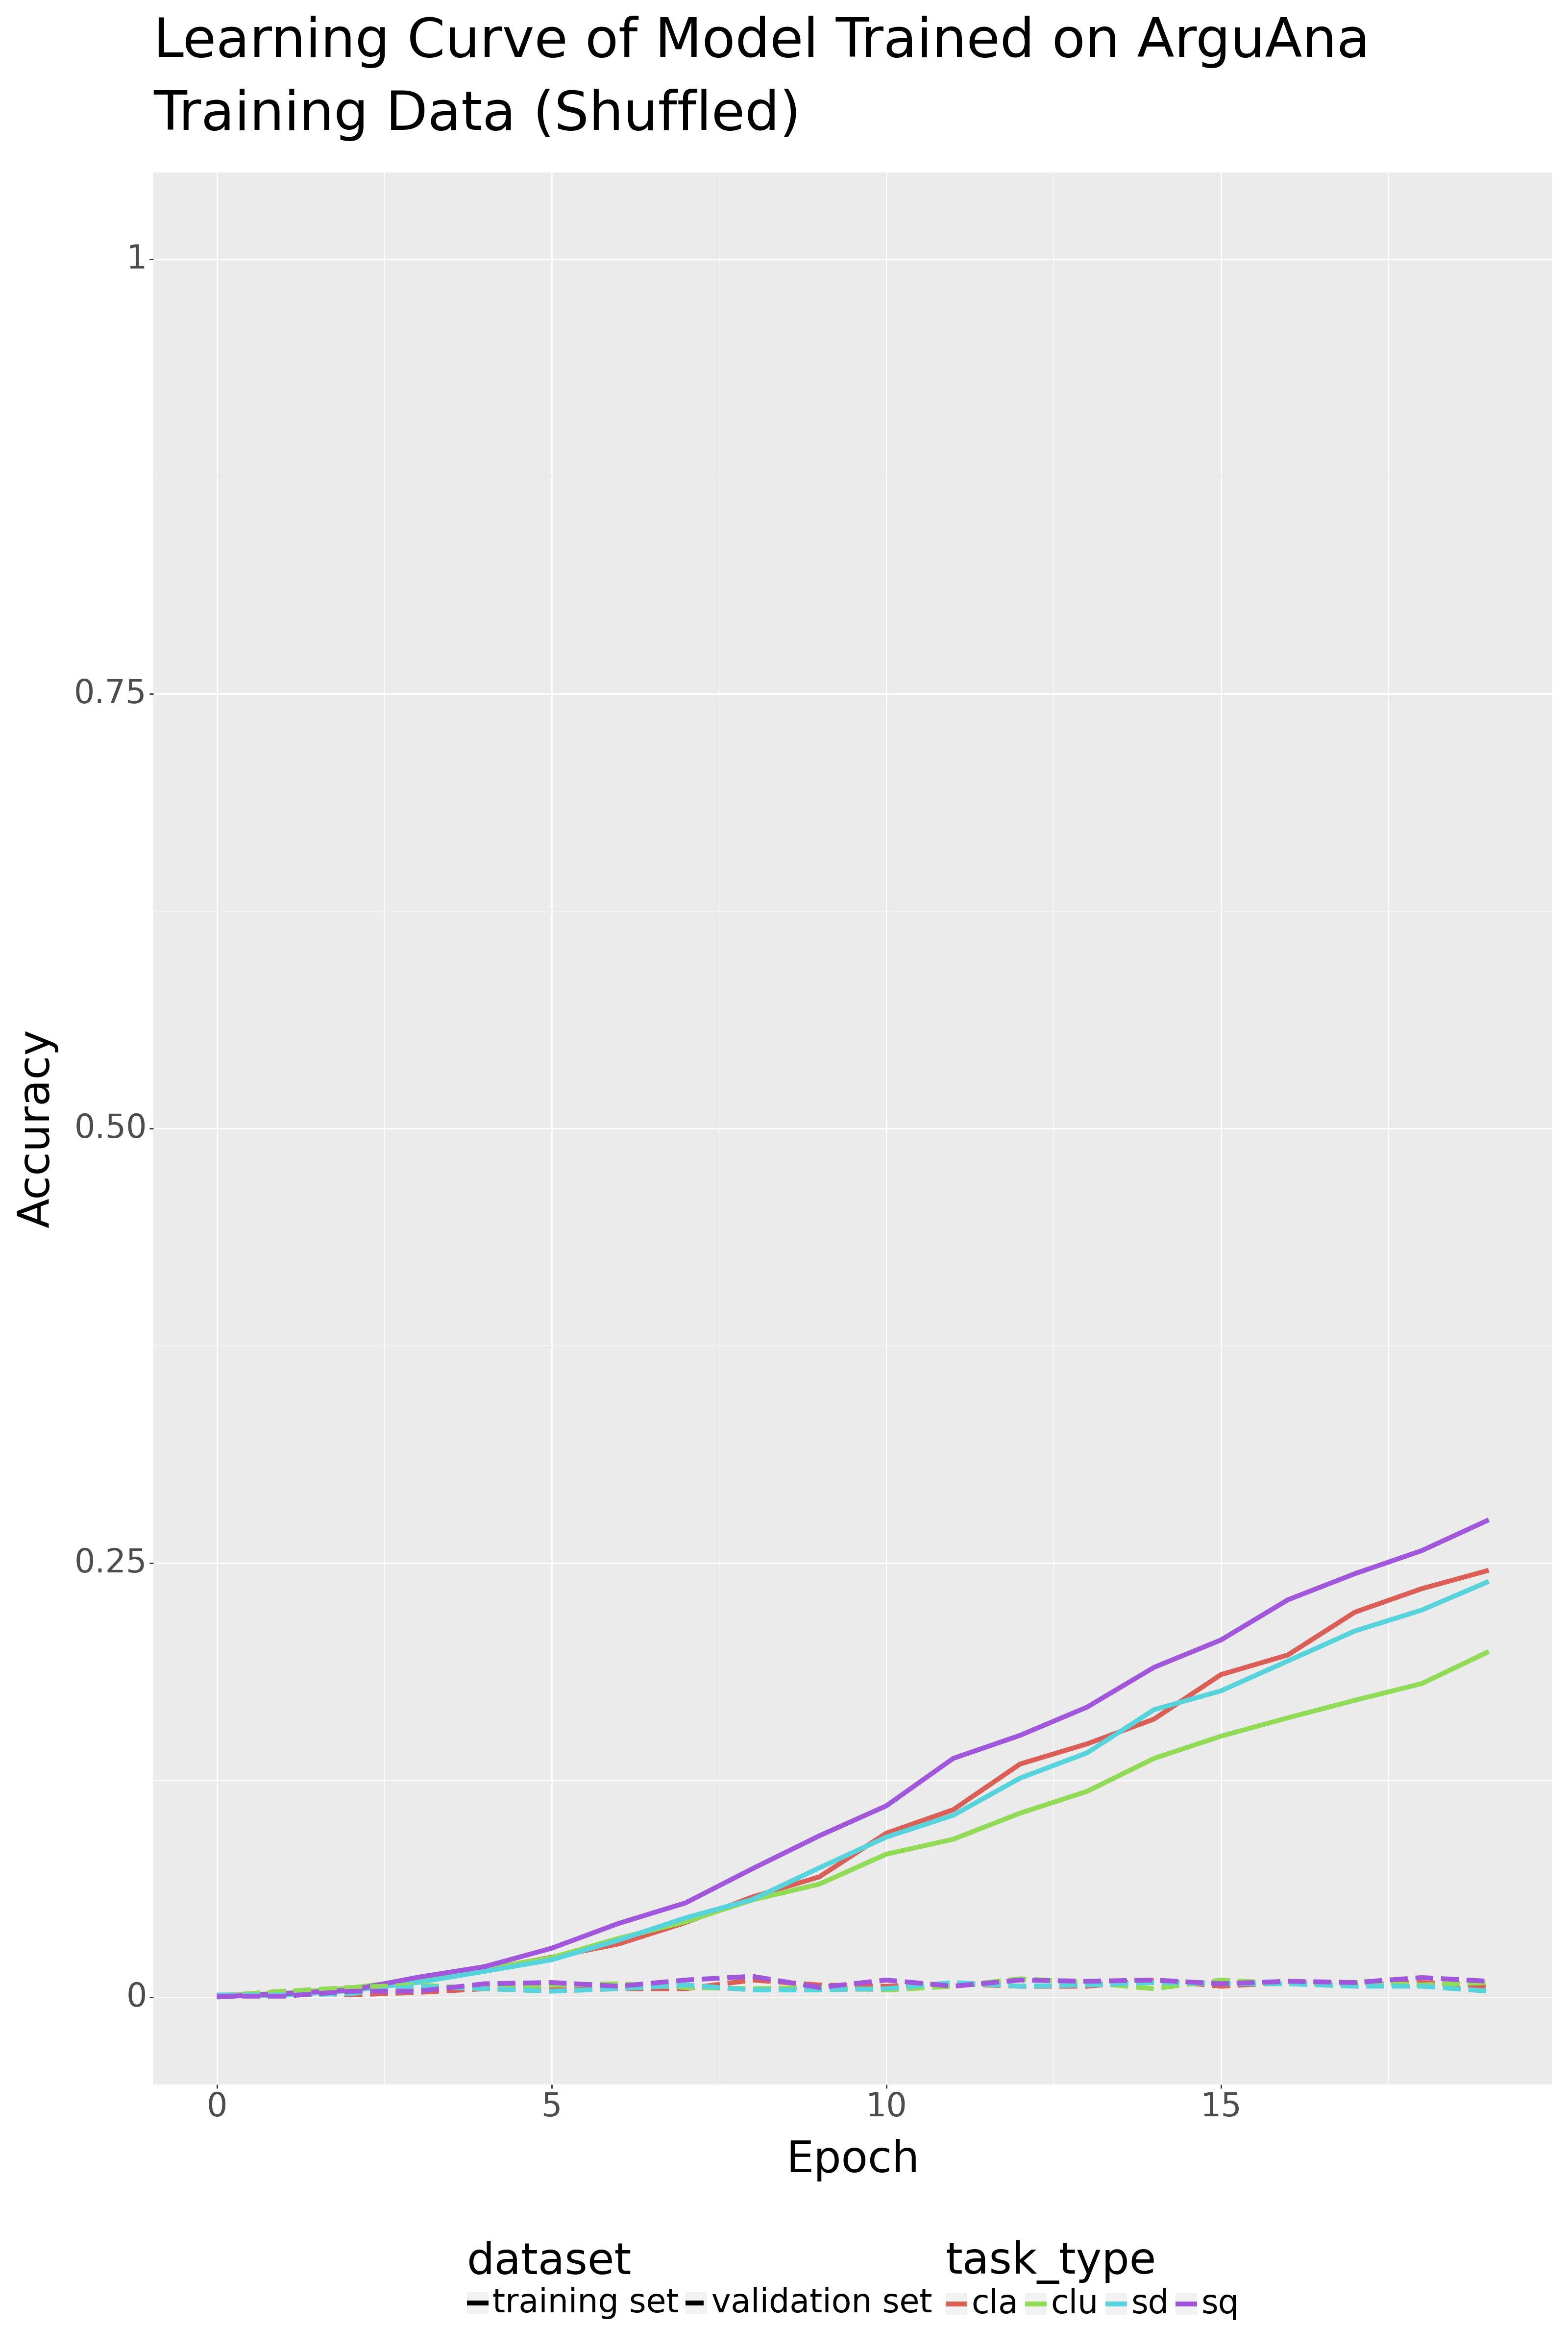

<Figure Size: (1600 x 2400)>

In [77]:
nomic_shuffled_combined_training_plot

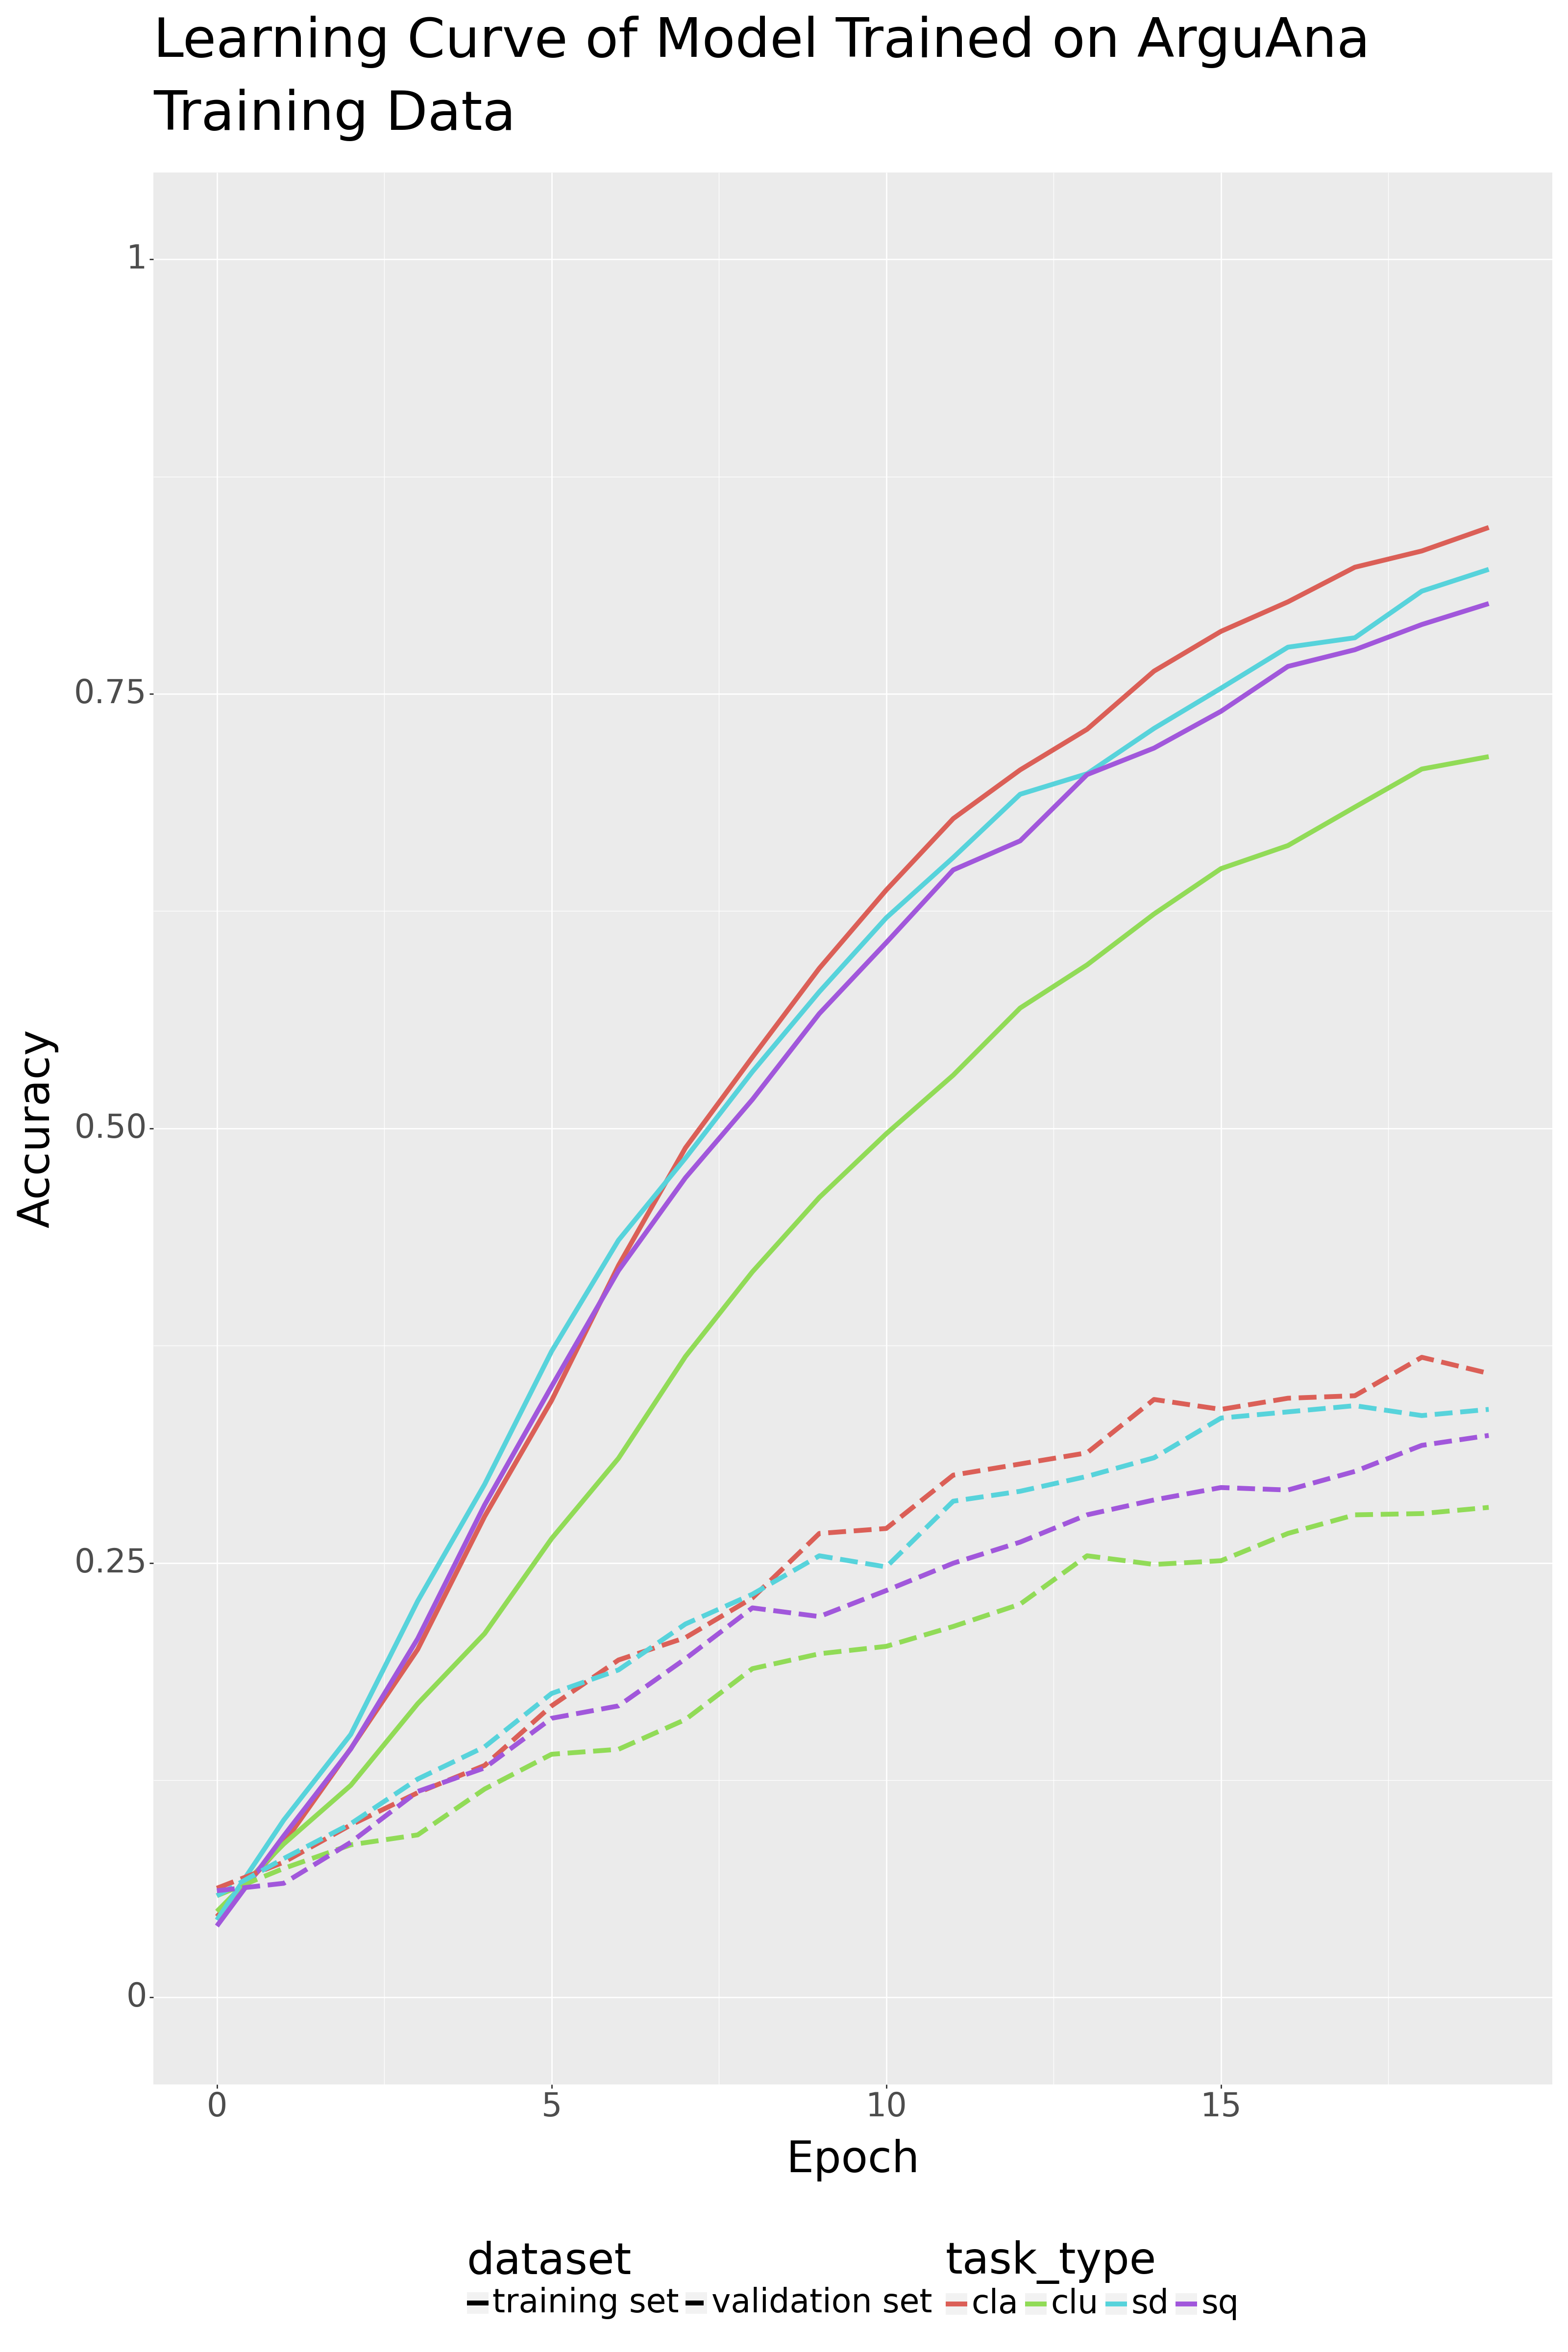

<Figure Size: (1600 x 2400)>

In [80]:
nomic_combined_training_plot

## Export to OSF

In [81]:
nomic_autoencoder_file_path = 'current-data-dump/nomic-autoencoder'
nomic_autoencoder_file_path_zip = 'current-data-dump/nomic-autoencoder'
shutil.make_archive(nomic_autoencoder_file_path_zip, 'zip', nomic_autoencoder_file_path)
print(f"Zip file created at: {nomic_autoencoder_file_path_zip}")
result = subprocess.run([f"osf -p sakjg upload --force {nomic_autoencoder_file_path_zip}.zip data-dump/nomic-autoencoder/nomic_autoencoder.zip"], shell=True, capture_output=True, text=True)
print(result.stderr)
print(f"File: {nomic_autoencoder_file_path_zip} uploaded at osfstorage")

Zip file created at: current-data-dump/nomic-autoencoder

File: current-data-dump/nomic-autoencoder uploaded at osfstorage
